Импорт основных библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Считываем все нужные таблицы

In [2]:
df = pd.read_excel("/content/drive/MyDrive/ML_3/train.xlsx")
df.head()

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300


Сортируем датасет, чтобы лаги были корректными

In [3]:
df = df.sort_values(by='dt').reset_index(drop=True)
df

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
...,...,...
395,2022-08-01,47500
396,2022-08-08,49000
397,2022-08-15,47500
398,2022-08-22,46500


Размер Датасета

In [ ]:
df.shape

(400, 2)

нулевых значений нет

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


# Проверка на стационарность, авторкорреляцию

<Axes: ylabel='Цена на арматуру'>

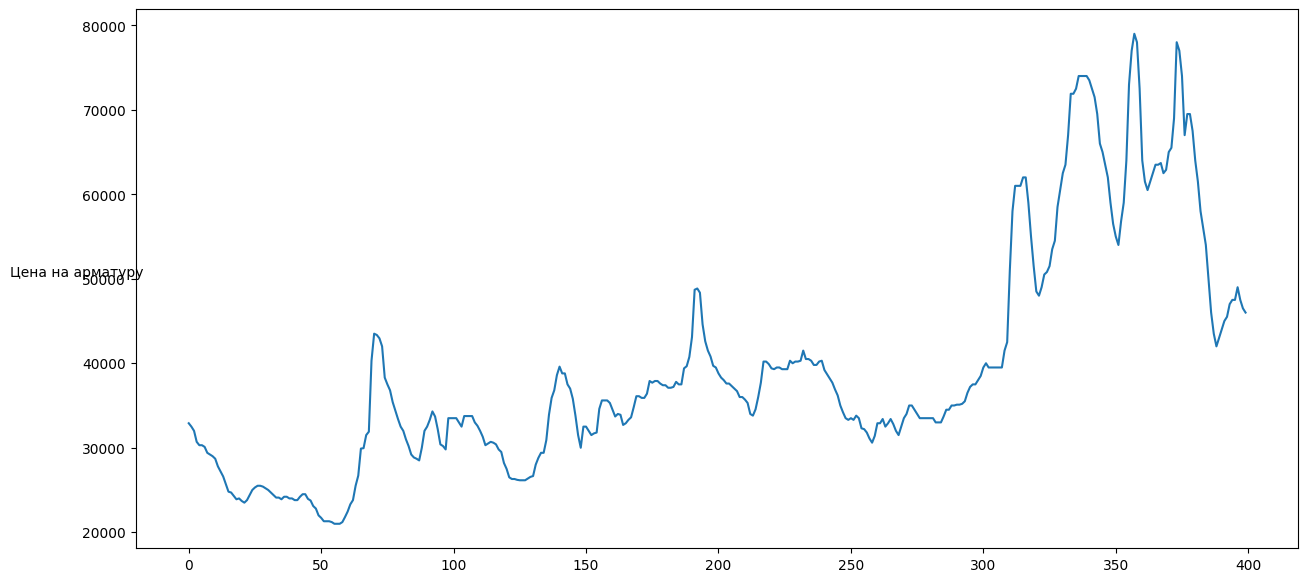

In [ ]:
plt.figure(figsize=(15, 7))
plt.ylabel('Цена на арматуру', rotation=0)
df['Цена на арматуру'].plot()

Судя по графику, временной ряд случайный. Однако, можно предположить, что он все таки увеличивается. Чтобы не гадать, можно это проверить

In [ ]:
!pip install statsmodels==0.14.4

In [ ]:
df["Цена на арматуру"]

,Цена на арматуру
0,32900
1,32500
2,32000
3,30700
4,30300
...,...
395,47500
396,49000
397,47500
398,46500


In [ ]:
df.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [ ]:
df['Цена на арматуру'].describe()

,Цена на арматуру
count,400.000000
mean,39229.475000
std,13407.979668
min,21000.000000
25%,31075.000000
50%,35450.000000
75%,42000.000000
max,79000.000000


Приводим дату к формату даты и делаем её индексом

In [4]:
df['dt'] = pd.to_datetime(df['dt'], format='%m-%d-%Y')

df = df.set_index(['dt'])

Разложение ряда на компоненты

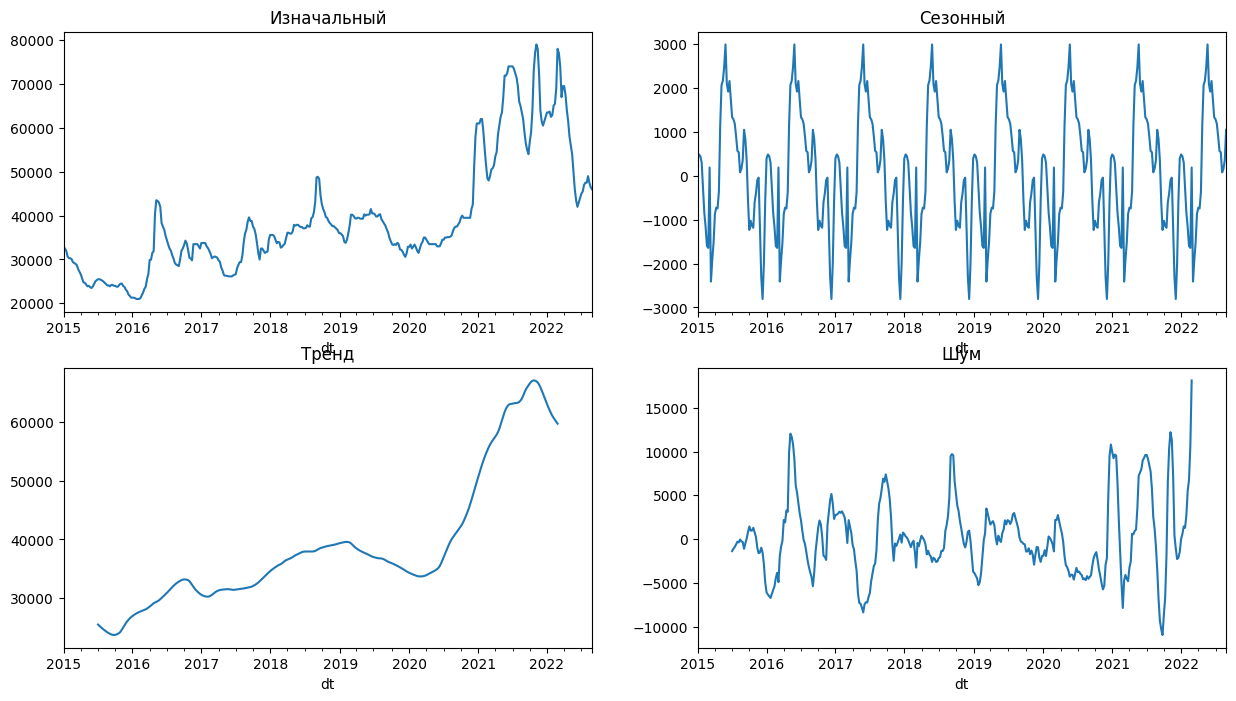

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

decompose = seasonal_decompose(df[['Цена на арматуру']])

ax[0, 0].set_title('Изначальный')
ax[0, 1].set_title('Сезонный')
ax[1, 0].set_title('Тренд')
ax[1, 1].set_title('Шум')

decompose.observed.plot(ax=ax[0, 0])
decompose.seasonal.plot(ax=ax[0, 1])
decompose.trend.plot(ax=ax[1, 0])
decompose.resid.plot(ax=ax[1, 1]);


In [6]:
from statsmodels.tsa.seasonal import STL

values = np.sin(np.linspace(0, 40, 400)) * 10 + np.arange(400)
data = pd.Series(values, index=df['Цена на арматуру'])

decomposition = STL(df, seasonal=13).fit()
trend = decomposition.trend
seasonal = decomposition.seasonal
df['trend'] = trend
df['season'] = seasonal

Тест на стационарность

In [8]:
from statsmodels.tsa.stattools import adfuller, acf

result = adfuller(df['Цена на арматуру'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -1.9258699893713456
p-value: 0.31999061025699155


можно предположить, т.к. p > 0.05, что временной ряд нестационарен
Надо убрать тренд и сезонность

Автокорреляция и частичная автокорреляция

Здесь мы можем увидеть важные лаги

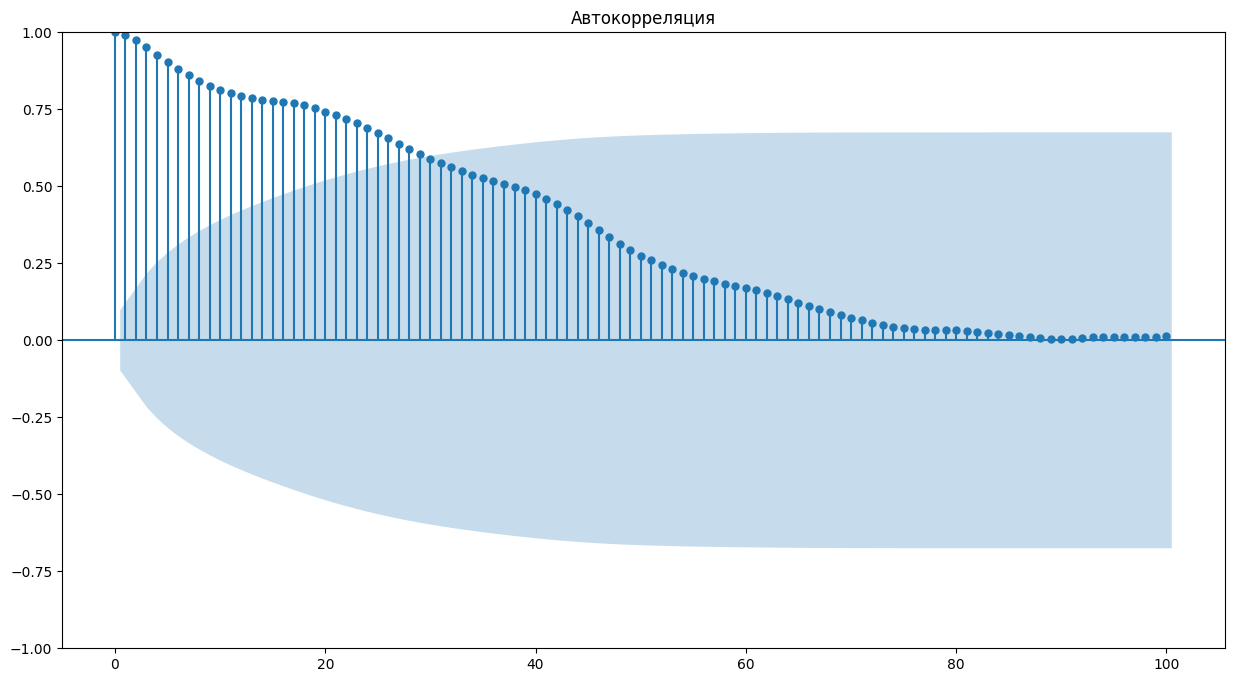

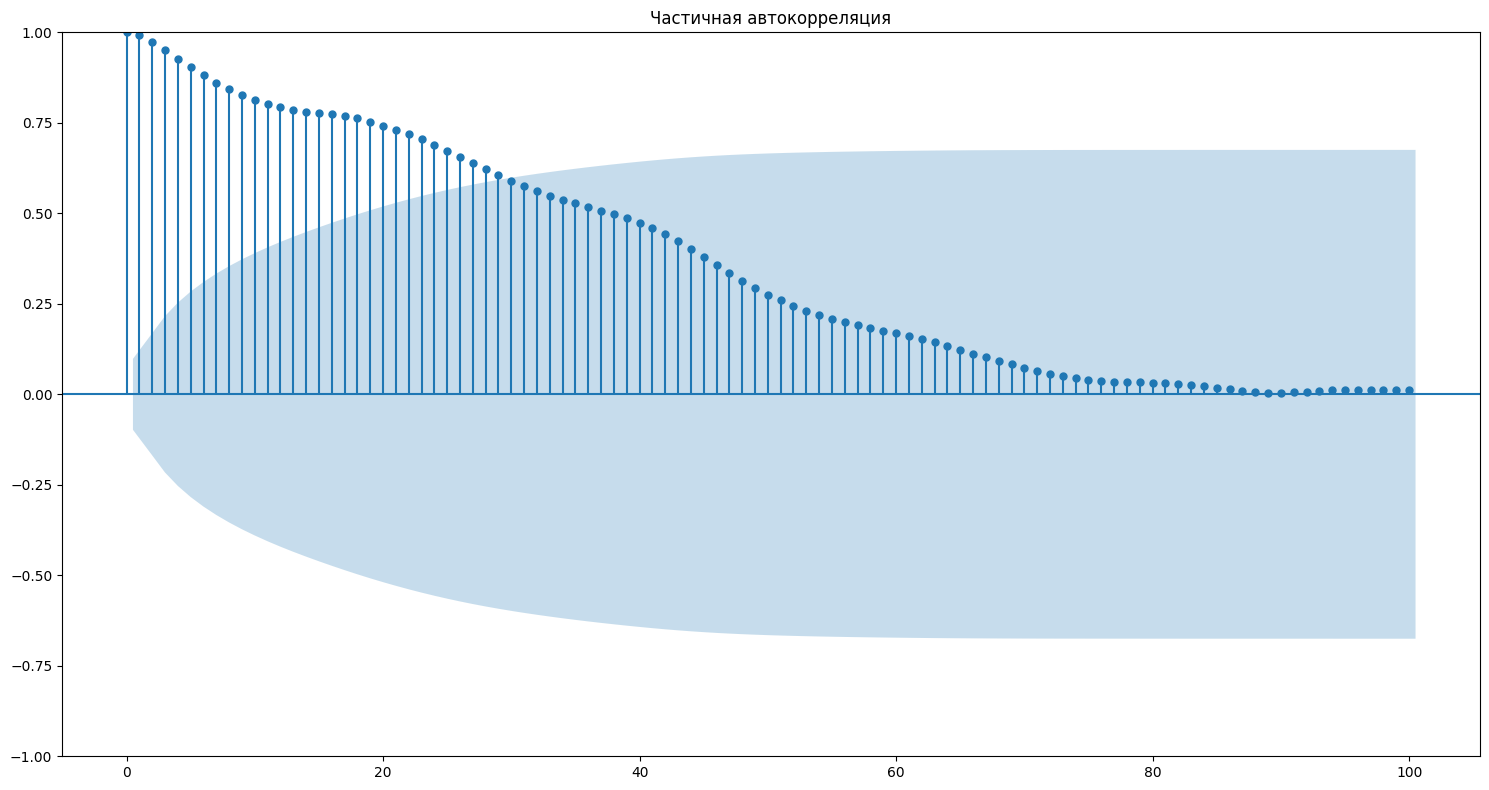

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15,8))
plot_acf(df['Цена на арматуру'], lags=100, ax=plt.gca())
plt.title('Автокорреляция')

plt.figure(figsize=(15,8))

plot_acf(df['Цена на арматуру'], lags=100, ax=plt.gca())
plt.title('Частичная автокорреляция')

plt.tight_layout()
plt.show()

Основные 25 лагов не входят в закрашенный промежток, значит значение из этого диапазона можно использовать как признаки для модели

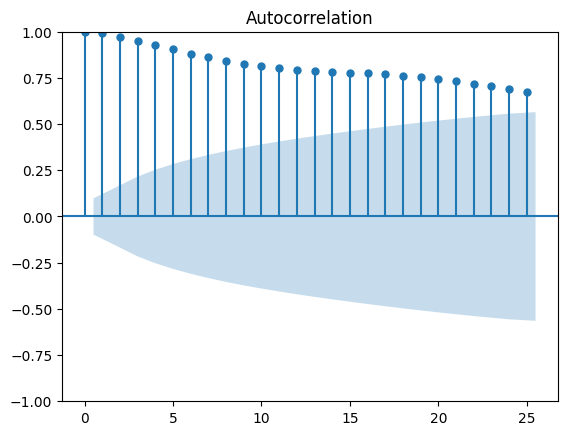

In [ ]:
plot_acf(df, lags=25)
plt.show()

# Работа с выбросами

<Axes: >

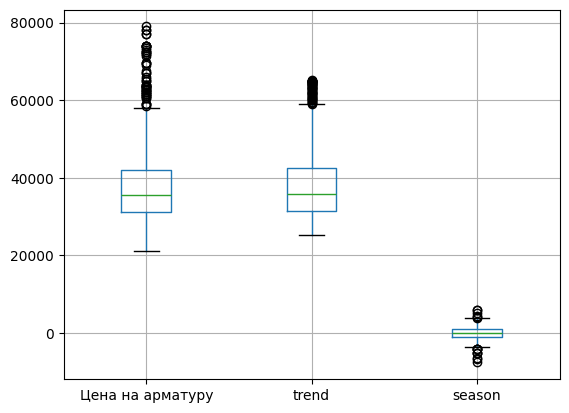

In [ ]:
df.boxplot()

# Замена выбросов



Данных очень мало. Так что просто удалить выбросы было бы слишком затратно

Поэтому, можно поробовать сгладить или заменить выбросы с помощью линейной интерполяции или скользящего среднего

In [50]:
# threshold = 74000
# outliers = df['Цена на арматуру'] > threshold

# df['Цена_Clean'] = df['Цена на арматуру'].copy()
# df.loc[outliers, 'Цена_Clean'] = np.nan
# df['Цена_Clean'] = df['Цена_Clean'].interpolate(method='linear')


df['Цена_Smooth'] = df['Цена на арматуру'].rolling(window=52, center=True).mean()

# plt.figure(figsize=(14, 6))

# plt.plot(df.index, df['Цена на арматуру'], label="Оригинальные данные", alpha=0.5, color="gray")
# plt.plot(df.index, df["Цена_Clean"], label="После линейной интерполяции", linestyle="--", color="blue")
# plt.plot(df.index, df["Цена_Smooth"], label="После скользящего среднего", linestyle="-", color="red")

# plt.axhline(y=threshold, color="black", linestyle="--", label="Порог выбросов")
# plt.legend()
# plt.xlabel("Дата")
# plt.ylabel("Цена")
# plt.title("Обработка выбросов: интерполяция и сглаживание")
# plt.show()

# Преобразование временного ряда в стационарный

Надо сделать стационарный временной ряд, и использовать его как признак при обучении модели


Логарифмирование

In [29]:
df['Цена_seasonal_diff'] = (df['Цена на арматуру']).diff(periods=7)

Лаги

Данные по каждому понедельнику, значит в году таких недель может быть 52

In [36]:
df['lag_1'] = df['Цена на арматуру'].shift(1)
df['lag_4'] = df['Цена на арматуру'].shift(4)
df['lag_52'] = df['Цена на арматуру'].shift(52)

Временные признаки

In [37]:

df['week_of_year'] = df.index.isocalendar().week  # номер недели в году (1-52)

df['week_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)


In [13]:
!pip install tensorflow

In [51]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)

df.iloc[:, :] = imputer.fit_transform(df)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0119 - val_loss: 0.0785
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0045 - val_loss: 0.0273
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0026 - val_loss: 0.0275
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0022 - val_loss: 0.0213
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0019 - val_loss: 0.0219
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0022 - val_loss: 0.0352
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0025 - val_loss: 0.0288
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016 - val_loss: 0.0203
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0017 - val_loss: 0.0242
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0010 - val_loss: 0.0225
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0015 - val_loss: 0.0207
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013 - val_loss: 0.0171
Epoch 13/20


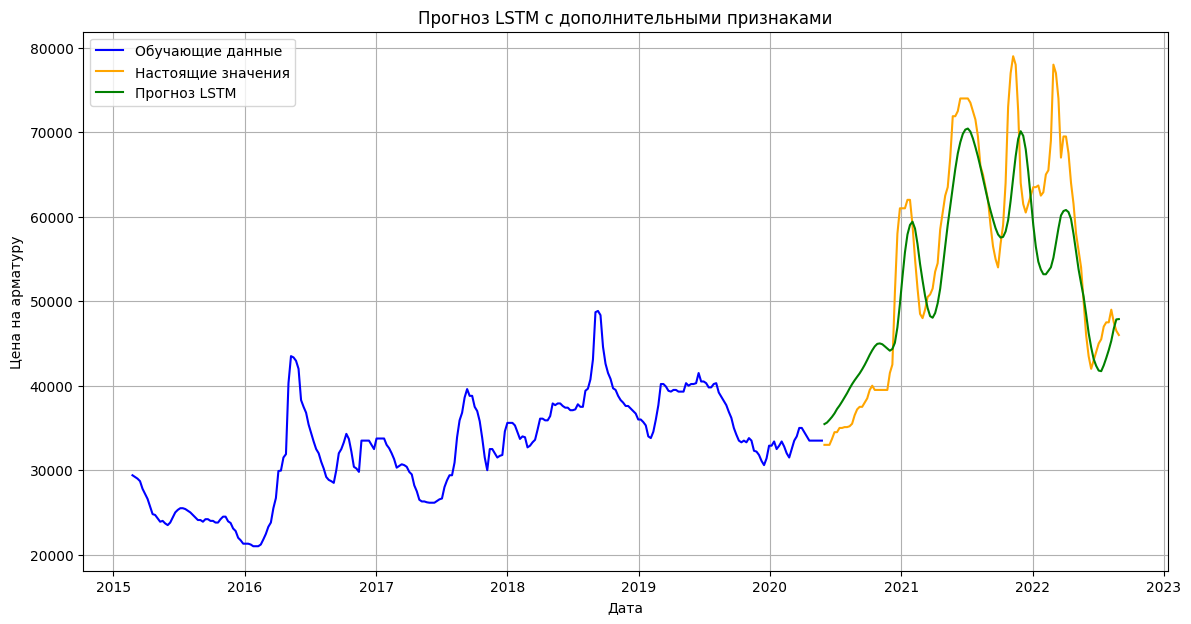

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error


df.index = pd.to_datetime(df.index)


target = df['Цена на арматуру'].values.reshape(-1, 1)
features = df.drop(columns=['Цена на арматуру']).values


scaler_target = MinMaxScaler(feature_range=(0, 1))
scaler_features = MinMaxScaler(feature_range=(0, 1))

target_scaled = scaler_target.fit_transform(target)
features_scaled = scaler_features.fit_transform(features)

# Объединение целевой переменной и дополнительных признаков
data_scaled = np.hstack((target_scaled, features_scaled))

# Функция для создания датасета с временными шагами
def create_dataset(data, timesteps=1):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:(i + timesteps), :])  # Все признаки
        y.append(data[i + timesteps, 0])  # Целевая переменная
    return np.array(X), np.array(y)

# Параметры
timesteps = 7  # Количество временных шагов (можно настроить)
X, y = create_dataset(data_scaled, timesteps)

# Разделение на обучающую и тестовую выборки
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Преобразование данных в 3D-формат (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Создание модели LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timesteps, X_train.shape[2])))  # Первый LSTM-слой
model.add(LSTM(50, return_sequences=False))  # Второй LSTM-слой
model.add(Dense(1))  # Выходной слой

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Прогнозирование
y_pred_scaled = model.predict(X_test)

# Обратное преобразование масштаба данных
y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Оценка качества модели
mse = mean_squared_error(y_test_original, y_pred)
rmse = mse ** 0.5
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')

# Визуализация результатов
plt.figure(figsize=(14, 7))
plt.plot(df.index[timesteps:train_size + timesteps], scaler_target.inverse_transform(y_train.reshape(-1, 1)), label='Обучающие данные', color='blue')
plt.plot(df.index[train_size + timesteps:], y_test_original, label='Настоящие значения', color='orange')
plt.plot(df.index[train_size + timesteps:], y_pred, label='Прогноз LSTM', color='green')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('Прогноз LSTM с дополнительными признаками')
plt.legend()
plt.grid()
plt.show()